In [1]:
## April 24th, 2020
## purpose: what can we glean from COVID articles? Can we use NLP to see how has sentiment changed over time?
## By: Amanda Hutter

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os 
import datetime
from datetime import timedelta

import glob
import json


pd.set_option('display.max_columns', None)

In [3]:
#os.getcwd()
rootfolder = "/Users/amandahutter/Documents/PythonCode/KaggleFiles/COVID/CORD-19-research-challenge"
os.chdir(rootfolder)
os.listdir()

['CORD19-Analysis.ipynb',
 '.DS_Store',
 'custom_license',
 'metadata.readme',
 'json_schema.txt',
 'noncomm_use_subset',
 'cord_19_embeddings_4_17',
 'metadata.csv',
 '.ipynb_checkpoints',
 'biorxiv_medrxiv',
 'COVID.DATA.LIC.AGMT.pdf',
 'comm_use_subset']

## Read in Metadata file

In [4]:
date_cols = ['publish_time']
meta = pd.read_csv("metadata.csv", engine = 'python', 
                   parse_dates = date_cols, 
                   dtype = {'pubmed_id': str, 'doi': str, 'Microsoft Academic Paper ID':str}
                  )

In [5]:
meta.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [6]:
meta.isna().sum()

cord_uid                           0
sha                            13374
source_x                           0
title                            158
doi                             3340
pmcid                           8746
pubmed_id                      14340
license                            0
abstract                        9230
publish_time                       8
authors                         2279
journal                         5242
Microsoft Academic Paper ID    51434
WHO #Covidence                 50630
has_pdf_parse                      0
has_pmc_xml_parse                  0
full_text_file                  8604
url                              302
dtype: int64

In [7]:
meta.shape

(52398, 18)

In [8]:
meta.dtypes

cord_uid                               object
sha                                    object
source_x                               object
title                                  object
doi                                    object
pmcid                                  object
pubmed_id                              object
license                                object
abstract                               object
publish_time                   datetime64[ns]
authors                                object
journal                                object
Microsoft Academic Paper ID            object
WHO #Covidence                         object
has_pdf_parse                            bool
has_pmc_xml_parse                        bool
full_text_file                         object
url                                    object
dtype: object

In [9]:
## Drop the rows which are missing variables of interest
meta.dropna(subset=['publish_time', 'abstract','title'], inplace = True)

meta.shape

(43012, 18)

In [10]:
# What do the titles say?
meta.iloc[0]['title']

'Airborne rhinovirus detection and effect of ultraviolet irradiation on detection by a semi-nested RT-PCR assay'

In [11]:
meta.iloc[1]['title']

'Discovering human history from stomach bacteria'

In [12]:
meta.iloc[2]['title']

'A new recruit for the army of the men of death'

In [13]:
# What do the abstracts say?
meta.iloc[0]['abstract']

'BACKGROUND: Rhinovirus, the most common cause of upper respiratory tract infections, has been implicated in asthma exacerbations and possibly asthma deaths. Although the method of transmission of rhinoviruses is disputed, several studies have demonstrated that aerosol transmission is a likely method of transmission among adults. As a first step in studies of possible airborne rhinovirus transmission, we developed methods to detect aerosolized rhinovirus by extending existing technology for detecting infectious agents in nasal specimens. METHODS: We aerosolized rhinovirus in a small aerosol chamber. Experiments were conducted with decreasing concentrations of rhinovirus. To determine the effect of UV irradiation on detection of rhinoviral aerosols, we also conducted experiments in which we exposed aerosols to a UV dose of 684 mJ/m(2). Aerosols were collected on Teflon filters and rhinovirus recovered in Qiagen AVL buffer using the Qiagen QIAamp Viral RNA Kit (Qiagen Corp., Valencia, Ca

In [14]:
# What time period are we working with?
print("Oldest article:", min(meta['publish_time']))
print("Newest article:", max(meta['publish_time']))

## Why is there an article from the future?
meta['year'] = meta['publish_time'].dt.year

Oldest article: 1955-10-31 00:00:00
Newest article: 2020-12-31 00:00:00


In [15]:
## Are there more articles in recent months and years, as this pandemic grew nearer?

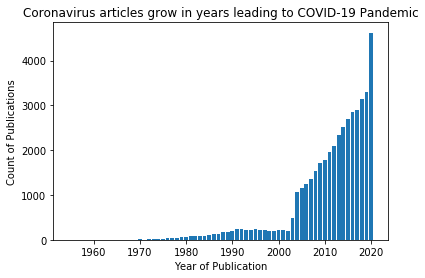

In [16]:
count_by_year = meta[['year','cord_uid']].groupby(['year']).count()
count_by_year = count_by_year.reset_index()
count_by_year['year'] = count_by_year['year'].astype(int)
count_by_year = count_by_year.rename(columns = {'cord_uid':'count'})

count_by_year.head()

x = count_by_year['year']
y = count_by_year['count']

plt.xlabel("Year of Publication")
plt.ylabel("Count of Publications")

plt.title("Coronavirus articles grow in years leading to COVID-19 Pandemic")

plt.bar(x, y)

plt.show()

In [17]:
# Which journal is the most popular for publishing papers on COVID? 

count_by_journal = meta[['journal','cord_uid']].groupby('journal').count().reset_index()

count_by_journal = count_by_journal.rename(columns = {'cord_uid':'count'})

count_by_journal.sort_values(by = 'count', ascending = False).head(15)


,journal,count
3443,Journal of Virology,1722
4231,PLoS One,1567
5451,Virology,816
1709,Emerg Infect Dis,572
5466,Viruses,563
464,Arch Virol,495
4827,Sci Rep,492
5459,Virus Research,437
5422,Veterinary Microbiology,408
3442,Journal of Virological Methods,363


## Read in CORD19 Embeddings File 

In [18]:
#embed =  pd.read_csv("cord_19_embeddings_4_17/cord_19_embeddings_4_17.csv", engine = 'python')

In [19]:
#embed.head()

In [20]:
#embed.shape

In [21]:
#embed.isna().sum()

In [22]:
## This is the same number of rows as the Metadata set

In [23]:
meta.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,year
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,2003
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,2003
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,2003
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,2003
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,2003


## Weekly Bar Chart of Publications

In [24]:
def prior_sun(dt):
    return dt - timedelta(days =((dt.isoweekday() + 0) % 7))

meta['weekStart'] = meta['publish_time'].apply(prior_sun)

In [25]:
#meta['weekStart'] = meta['publish_time'].apply(prior_sun)

In [26]:
start_date = "2019-5-1"
end_date = "2020-4-30"

after_start_date = meta["weekStart"] >= start_date
before_end_date = meta["weekStart"] <= end_date
between_two_dates = after_start_date & before_end_date
recent_meta = meta.loc[between_two_dates]

/Users/amandahutter/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


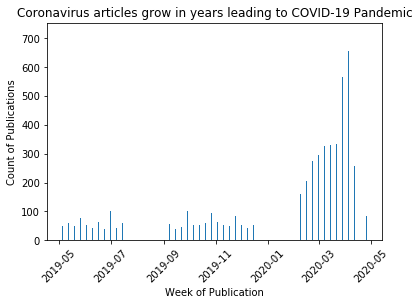

In [27]:
count_by_week = recent_meta[['weekStart','cord_uid']].groupby(['weekStart']).count()
count_by_week = count_by_week.reset_index()
count_by_week['weekStart'] = count_by_week['weekStart']
count_by_week = count_by_week.rename(columns = {'cord_uid':'count'})

count_by_week.head()

x = count_by_week['weekStart']
y = count_by_week['count']

plt.xticks(rotation=45)
plt.xlabel("Week of Publication")
plt.ylabel("Count of Publications")
plt.title("Coronavirus articles grow in years leading to COVID-19 Pandemic")
plt.bar(x, y)
plt.show()

## Add NLP stuff to abstracts

In [28]:
import re 

# Import NLTK to assist with removing the non important words 
import nltk 

from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amandahutter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
#recent_meta['abstract']

#recent_meta.iloc[0][8]

recent_meta.iloc[0]['abstract']

'In the United States, outbreaks of avian influenza H5 and H7 virus infections in poultry have raised concern about the risk for infections in humans. We reviewed the data collected during 2014–2017 and found no human infections among 4,555 exposed responders who were wearing protection.'

In [30]:
# Remove the non important words 
abstract = re.sub(pattern = '[^a-zA-Z]', repl = ' ', string = recent_meta.iloc[0]['abstract']) 
print(abstract)

# Lowercase  
abstract = abstract.lower()
print(abstract)

# Split string
abstract = abstract.split()
print(abstract)

# Make Porter stemmer to stem our words, to remove suffix & prefix
ps = PorterStemmer()

# Keep the words in the list that are not in the Stopwords list 
abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))]
print(abstract)

# Convert back to string 
abstract = ' '.join(abstract)
print(abstract)

In the United States  outbreaks of avian influenza H  and H  virus infections in poultry have raised concern about the risk for infections in humans  We reviewed the data collected during           and found no human infections among       exposed responders who were wearing protection 
in the united states  outbreaks of avian influenza h  and h  virus infections in poultry have raised concern about the risk for infections in humans  we reviewed the data collected during           and found no human infections among       exposed responders who were wearing protection 
['in', 'the', 'united', 'states', 'outbreaks', 'of', 'avian', 'influenza', 'h', 'and', 'h', 'virus', 'infections', 'in', 'poultry', 'have', 'raised', 'concern', 'about', 'the', 'risk', 'for', 'infections', 'in', 'humans', 'we', 'reviewed', 'the', 'data', 'collected', 'during', 'and', 'found', 'no', 'human', 'infections', 'among', 'exposed', 'responders', 'who', 'were', 'wearing', 'protection']
['unit', 'state', 'outbreak

### Create Corpus of Abstracts

In [ ]:
# Loop through all reviews in your dataset and do above process 

# corpus refers to the cleaned reviews
abstract_corpus= []

for i in range (0, len(recent_meta)):
    abstract = re.sub(pattern = '[^a-zA-Z]', repl = ' ', string = recent_meta.iloc[i]['abstract'])
    abstract = abstract.lower()
    abstract = abstract.split()
    ps = PorterStemmer()
    abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))]
    abstract = ' '.join(abstract)
    abstract_corpus.append(abstract)
print(abstract_corpus[1:15])

## (II) NLTK-VADER: Add libraries for Unsupervised Sentiment Analysis 

### https://www.nltk.org/api/nltk.sentiment.html
### https://github.com/cjhutto/vaderSentiment

If you use the VADER sentiment analysis tools, please cite:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [ ]:
# https://medium.com/@Intellica.AI/vader-ibm-watson-or-textblob-which-is-better-for-unsupervised-sentiment-analysis-db4143a39445

#import nltk
nltk.download('vader_lexicon')

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    for key in sorted(ss):
        print('{0}: {1}, '.format(key, ss[key]), end='')
        print()
        
    #for key, val in ss.items():
    #    print(key)
    #    print(val)

### What is the Compound value? It uses the valence to measure overall sentiment. Typically, >0.05 is Positive, <-.05 is Negative, else it is Neutral

### https://github.com/cjhutto/vaderSentiment#about-the-scoring

In [ ]:
print(abstract_corpus[0])
get_vader_score(abstract_corpus[0])

In [ ]:
get_vader_score(abstract_corpus[1])

In [ ]:
get_vader_score(abstract_corpus[-1])

## (II.ii) TextBlob for Sentiment Analysis on Unstructured data

In [ ]:
from textblob import TextBlob

# Get the polarity score using below function
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    return polarity

In [ ]:
print(abstract_corpus[0])
get_textBlob_score(abstract_corpus[0])

In [ ]:
print(abstract_corpus[1])
get_textBlob_score(abstract_corpus[1])

In [ ]:
print(abstract_corpus[-1])
get_textBlob_score(abstract_corpus[-1])

In [ ]:
print(abstract_corpus[-10])
get_textBlob_score(abstract_corpus[-10])

Consider whether Textblob or NLTK Vader should be used to understand sentiment of publication headlines. NLTK Vader provides more granularity 

## (III) NLTK Vader POC

### Return to Vader  - Toy Example with Phrases

In [ ]:
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    dict_list.append(ss)
    

In [ ]:
list_of_phrases = ["I have the measles and the mumps", "We are the champions", "I do not like green eggs"]

dict_list = []

for i in range(0, len(list_of_phrases)):
    print(list_of_phrases[i])
    get_vader_score(list_of_phrases[i])

neg_list = []
neu_list = []
pos_list = []
compound_list = []

for i in range(0, len(dict_list)):
    neg_list.append(dict_list[i]["neg"])
    neu_list.append(dict_list[i]["neu"])
    pos_list.append(dict_list[i]["pos"])
    compound_list.append(dict_list[i]["compound"])

print(neg_list)
print(neu_list)
print(pos_list)
print(compound_list)

In [ ]:
vader_df = pd.DataFrame( list(zip(list_of_phrases, neg_list, neu_list, pos_list, compound_list)), columns = ["Phrases",'Negative','Neutral','Positive','Compound'])

In [ ]:
vader_df

In [ ]:
dict_list

### (III.i) Vader - Example with Abstract Corpus

In [ ]:
#abstract_corpus = corpus

In [ ]:
dict_list.clear

dict_list = []

for i in range(0, len(abstract_corpus)):
    get_vader_score(abstract_corpus[i])

In [ ]:
neg_list = []
neu_list = []
pos_list = []
compound_list = []
for i in range(0, len(dict_list)):
    neg_list.append(dict_list[i]["neg"])
    neu_list.append(dict_list[i]["neu"])
    pos_list.append(dict_list[i]["pos"])
    compound_list.append(dict_list[i]["compound"])

In [ ]:
vader_df = pd.DataFrame( list(zip(abstract_corpus, neg_list, neu_list, pos_list, compound_list)), columns = ["Abstracts",'Negative','Neutral','Positive','Compound'])

In [ ]:
vader_df.head()

In [ ]:
vader_df.describe()

In [ ]:
vader_df.index

In [ ]:
#recent_meta.head()

In [ ]:
print(recent_meta.index)

recent_meta = recent_meta.reset_index()

print(recent_meta.index)

In [ ]:
recent_vader = pd.concat([recent_meta, vader_df], axis = 1)

In [ ]:
print(recent_vader.shape)
recent_vader.head()

### Compound Sentiment weekly has a slightly decreasing trend entering 2020

In [ ]:
compound_by_week = recent_vader[['weekStart','Compound']].groupby('weekStart').median()
compound_by_week = compound_by_week.reset_index()

x = compound_by_week['weekStart']
y = compound_by_week['Compound']

plt.ylabel("Average Compound Score")
plt.xlabel("Week of publication")
plt.title("Average Compound Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Abstracts with Negative sentiment are Increasing in 2020

In [ ]:
negative_by_week = recent_vader[['weekStart','Negative']].groupby('weekStart').median()
negative_by_week = negative_by_week.reset_index()

x = negative_by_week['weekStart']
y = negative_by_week['Negative']

plt.ylabel("Average Negative Score")
plt.xlabel("Week of publication")
plt.title("Average Negative Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Positive Sentiment is increasing with Abstracts Published in 2020 

In [ ]:
positive_by_week = recent_vader[['weekStart','Positive']].groupby('weekStart').median()
positive_by_week = positive_by_week.reset_index()

x = positive_by_week['weekStart']
y = positive_by_week['Positive']

plt.ylabel("Average Positive Score")
plt.xlabel("Week of publication")
plt.title("Average Positive Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Neutral Sentiment Abstracts have decreased through 2020

In [ ]:
neutral_by_week = recent_vader[['weekStart','Neutral']].groupby('weekStart').median()
neutral_by_week = neutral_by_week.reset_index()

x = neutral_by_week['weekStart']
y = neutral_by_week['Neutral']

plt.ylabel("Average Positive Score")
plt.xlabel("Week of publication")
plt.title("Average Neutral Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Analyze the Positive/Negative scores using Vader on Abstracts with given thresholds for Compound Score

In [ ]:
recent_vader['Sentiment'] = 'Neutral' # Default
recent_vader.loc[recent_vader['Compound'] <= -.05, 'Sentiment'] = 'Negative' 
recent_vader.loc[recent_vader['Compound'] >= 0.05, 'Sentiment'] = 'Positive'

recent_vader['POS'] = 0
recent_vader.loc[recent_vader['Sentiment'] == "Positive", "POS"] = 1

recent_vader['NEG'] = 0
recent_vader.loc[recent_vader['Sentiment'] == "Negative", "NEG"] = 1

recent_vader['NEU'] = 0
recent_vader.loc[recent_vader['Sentiment'] == "Neutral", "NEU"] = 1

recent_vader.head()

## Show Volume of Positive, Negative, and Neutral Abstracts over time 

In [ ]:
# Overall, abstracts are Positive or Negative, fewer Neutral using compound score
recent_vader[['weekStart', 'Sentiment']].groupby(['Sentiment']).count()

In [ ]:
## TODO: create groupby and plot here
sentiment_by_week = recent_vader[['weekStart', 'Sentiment','cord_uid']].groupby(['weekStart','Sentiment']).count()
sentiment_by_week = sentiment_by_week.reset_index()
sentiment_by_week.rename(columns = {'cord_uid': 'Count'}, inplace = True)

sentiment_by_week.head(9)

### Weekly Sentiments of Abstracts with Vader Score 

In [ ]:
weekly_sentiment_abstracts = recent_vader[['weekStart', 'POS','NEU','NEG']].groupby('weekStart').sum().reset_index()

plt.plot('weekStart', 'POS', data = weekly_sentiment_abstracts, color = 'skyblue', label = "Positive")
plt.plot('weekStart', 'NEG', data = weekly_sentiment_abstracts, color = 'darkred', label = "Negative")
plt.plot('weekStart', 'NEU', data = weekly_sentiment_abstracts, color = 'springgreen', label = "Neutral")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.title("Sentiment of Abstracts written about COVID-19 using NLTK Vader Score")
plt.legend()

plt.show()

## (III.ii) Vader with Title Corpus

In [ ]:
# Loop through all reviews in your dataset and do above process 

# corpus refers to the cleaned reviews
title_corpus= []

for i in range (0, len(recent_meta)):
    abstract = re.sub(pattern = '[^a-zA-Z]', repl = ' ', string = recent_meta.iloc[i]['title'])
    abstract = abstract.lower()
    abstract = abstract.split()
    ps = PorterStemmer()
    abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))]
    abstract = ' '.join(abstract)
    title_corpus.append(abstract)
print(title_corpus[1:15])

In [ ]:
dict_list.clear

dict_list = []

for i in range(0, len(title_corpus)):
    get_vader_score(title_corpus[i])

In [ ]:
neg_list = []
neu_list = []
pos_list = []
compound_list = []
for i in range(0, len(dict_list)):
    neg_list.append(dict_list[i]["neg"])
    neu_list.append(dict_list[i]["neu"])
    pos_list.append(dict_list[i]["pos"])
    compound_list.append(dict_list[i]["compound"])

In [ ]:
title_vader = pd.DataFrame(list(zip(title_corpus, neg_list, neu_list, pos_list, compound_list)),
                        columns = ["Titles",'Negative','Neutral','Positive','Compound'])

In [ ]:
title_vader.head()

In [ ]:
title_vader.describe()

### Merge datasets for Vader + Title

In [ ]:
recent_title = pd.concat([recent_meta, title_vader], axis = 1)

In [ ]:
recent_title.head()

### Compound Titles

In [ ]:
compound_by_week = recent_title[['weekStart','Compound']].groupby('weekStart').median()
compound_by_week = compound_by_week.reset_index()

x = compound_by_week['weekStart']
y = compound_by_week['Compound']

plt.ylabel("Average Compound Score")
plt.xlabel("Week of publication")
plt.title("Average Compound Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Negative Titles

In [ ]:
negative_by_week = recent_title[['weekStart','Negative']].groupby('weekStart').median()
negative_by_week = negative_by_week.reset_index()

x = negative_by_week['weekStart']
y = negative_by_week['Negative']

plt.ylabel("Average Negative Score")
plt.xlabel("Week of publication")
plt.title("Average Negative Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Positive Titles

In [ ]:
positive_by_week = recent_title[['weekStart','Positive']].groupby('weekStart').median()
positive_by_week = positive_by_week.reset_index()

x = positive_by_week['weekStart']
y = positive_by_week['Positive']

plt.ylabel("Average Positive Score")
plt.xlabel("Week of publication")
plt.title("Average Positive Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Neutral Titles still fairly common, but with some non-neutral spikes in 2020

In [ ]:
neutral_by_week = recent_title[['weekStart','Neutral']].groupby('weekStart').median()
neutral_by_week = neutral_by_week.reset_index()

x = neutral_by_week['weekStart']
y = neutral_by_week['Neutral']

plt.ylabel("Average Positive Score")
plt.xlabel("Week of publication")
plt.title("Average Neutral Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Use Vader Compound Score to determine if Title is mostly Positive, Negative, or Neutral 

In [ ]:
recent_title['Sentiment'] = 'Neutral' # Default
recent_title.loc[recent_title['Compound'] <= -.05, 'Sentiment'] = 'Negative' 
recent_title.loc[recent_title['Compound'] >= 0.05, 'Sentiment'] = 'Positive'

recent_title['POS'] = 0
recent_title.loc[recent_title['Sentiment'] == "Positive", "POS"] = 1

recent_title['NEG'] = 0
recent_title.loc[recent_title['Sentiment'] == "Negative", "NEG"] = 1

recent_title['NEU'] = 0
recent_title.loc[recent_title['Sentiment'] == "Neutral", "NEU"] = 1

recent_title.head()

### Show volume of Titles that are Positive, Neutral, or Negative 

In [ ]:
recent_title[['weekStart', 'Sentiment']].groupby(['Sentiment']).count().reset_index()

Titles are far more likely to be classified as Neutral than their respective abstracts 

### Show weekly Title sentiment using NLTK Vader

In [ ]:
weekly_sentiment_titles = recent_title[['weekStart', 'POS','NEU','NEG']].groupby('weekStart').sum().reset_index()

plt.plot('weekStart', 'POS', data = weekly_sentiment_titles, color = 'skyblue', label = "Positive")
plt.plot('weekStart', 'NEG', data = weekly_sentiment_titles, color = 'darkred', label = "Negative")
plt.plot('weekStart', 'NEU', data = weekly_sentiment_titles, color = 'springgreen', label = 'Neutral')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment of Titles written about COVID-19 using NLTK VADER Score")
plt.show()

### Compare the sentiment of Titles and Abstracts, by week 

In [ ]:
# Merge together these dataframes with weekly counts of sentiment 
sentiments_abs_tits_vader = pd.merge(weekly_sentiment_abstracts, weekly_sentiment_titles, how = 'left', on = 'weekStart')

sentiments_abs_tits_vader.rename(columns = 
                           {'POS_x':'POS_abstracts','POS_y':'POS_titles',
                           'NEU_x':'NEU_abstracts', 'NEU_y':'NEU_titles',
                           'NEG_x': 'NEG_abstracts', 'NEG_y': 'NEG_titles'},
                           inplace=True)
sentiments_abs_tits_vader.head()

In [ ]:
plt.plot('weekStart', 'POS_abstracts', data = sentiments_abs_tits_vader, color = 'skyblue', label = "Abstracts (+)")
plt.plot('weekStart', 'POS_titles', data = sentiments_abs_tits_vader, color = 'skyblue', linestyle = 'dashed', label = 'Titles (+)')
plt.plot('weekStart', 'NEG_abstracts', data = sentiments_abs_tits_vader, color = 'darkred', label = "Abstracts (-)")
plt.plot('weekStart', 'NEG_titles', data = sentiments_abs_tits_vader, color = 'darkred', linestyle = 'dashed', label = "Titles (-)")
plt.plot('weekStart', 'NEU_abstracts', data = sentiments_abs_tits_vader, color = 'springgreen', label = "Abstracts (0)")
plt.plot('weekStart', 'NEU_titles', data = sentiments_abs_tits_vader, color = 'springgreen', linestyle = 'dashed', label = "Titles (0)")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using NLTK Vader Score")
plt.show()

In [ ]:
plt.plot('weekStart', 'POS_abstracts', data = sentiments_abs_tits_vader, color = 'skyblue', label = "Abstracts (+)")
plt.plot('weekStart', 'POS_titles', data = sentiments_abs_tits_vader, color = 'skyblue', linestyle = 'dashed', label = 'Titles (+)')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using NLTK Vader Score")
plt.show()

In [ ]:
plt.plot('weekStart', 'NEG_abstracts', data = sentiments_abs_tits_vader, color = 'darkred', label = "Abstracts (-)")
plt.plot('weekStart', 'NEG_titles', data = sentiments_abs_tits_vader, color = 'darkred', linestyle = 'dashed', label = "Titles (-)")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using NLTK Vader Score")
plt.show()

In [ ]:
plt.plot('weekStart', 'NEU_abstracts', data = sentiments_abs_tits_vader, color = 'springgreen', label = "Abstracts (0)")
plt.plot('weekStart', 'NEU_titles', data = sentiments_abs_tits_vader, color = 'springgreen', linestyle = 'dashed', label = "Titles (0)")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using NLTK Vader Score")
plt.show()

## (IV) Using Textblob

### (IV) Textblob on Abstracts Corpus

In [ ]:
abstract_corpus[:3]

In [ ]:
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    subjectivity = TextBlob(sent).sentiment.subjectivity
    return polarity, subjectivity

In [ ]:
get_textBlob_score(abstract_corpus[10])

In [ ]:
textBlob_polar = []
textBlob_subj = []

for i in range(0, len(abstract_corpus)):
    polarity, subjectivity = get_textBlob_score(abstract_corpus[i])
    textBlob_polar.append(polarity)
    textBlob_subj.append(subjectivity)

In [ ]:
print("Min score:", min(textBlob_polar))
print("Max score:", max(textBlob_polar))
print("Length:",len(textBlob_polar))

print("Min score:", min(textBlob_subj))
print("Max score:", max(textBlob_subj))
print("Length:",len(textBlob_subj))

### Distribution from Textblob

In [ ]:
data = textBlob_polar
num_bins = 40 # <- number of bins for the histogram
plt.hist(data, num_bins)
plt.title("Histogram of Textblob Abstract Polarity")
plt.show()

data = textBlob_subj
num_bins = 40 # <- number of bins for the histogram
plt.hist(data, num_bins)
plt.title("Histogram of Textblob Abstract Subjectivity")
plt.show()

### Zip lists together - Abstracts Textblob

In [ ]:
abstract_textblob = pd.DataFrame(list(zip(abstract_corpus, textBlob_polar, textBlob_subj)),
                        columns = ["Abstracts",'Polarity','Subjectivity'])

abstract_textblob

In [ ]:
# Determine Overall Sentiment
abstract_textblob['Sentiment'] = "Neutral"
abstract_textblob.loc[abstract_textblob['Polarity'] < 0, 'Sentiment'] = 'Negative' 
abstract_textblob.loc[abstract_textblob['Polarity'] > 0, 'Sentiment'] = 'Positive'

# Determine POS, NEG, NEU binary columns
abstract_textblob['POS'] = 0
abstract_textblob.loc[abstract_textblob['Sentiment'] == "Positive", "POS"] = 1

abstract_textblob['NEG'] = 0
abstract_textblob.loc[abstract_textblob['Sentiment'] == "Negative", "NEG"] = 1

abstract_textblob['NEU'] = 0
abstract_textblob.loc[abstract_textblob['Sentiment'] == "Neutral", "NEU"] = 1

abstract_textblob.head()

### Merge Datasets for Abstracts + Textblob

In [ ]:
recent_textblob_abs = pd.concat([recent_meta, abstract_textblob], axis = 1)

recent_textblob_abs.head()

### Group by week charts for Polarity & Subjectivity

In [ ]:
polarity_by_week = recent_textblob_abs[['weekStart','Polarity']].groupby('weekStart').median()
polarity_by_week = polarity_by_week.reset_index()

x = polarity_by_week['weekStart']
y = polarity_by_week['Polarity']

plt.ylabel("Average Polarity Score")
plt.xlabel("Week of publication")
plt.title("Average Polarity Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

In [ ]:
subjectivity_by_week = recent_textblob_abs[['weekStart','Subjectivity']].groupby('weekStart').median()
subjectivity_by_week = subjectivity_by_week.reset_index()

x = subjectivity_by_week['weekStart']
y = subjectivity_by_week['Subjectivity']

plt.ylabel("Average Subjectivity Score")
plt.xlabel("Week of publication")
plt.title("Average Subjectivity Score, 2019 - 2020, COVID Abstracts")
plt.plot(x, y)
plt.show()

### Textblob Sentiment Grouping over the year

In [ ]:
recent_textblob_abs[['weekStart', 'Sentiment']].groupby(['Sentiment']).count().reset_index()

### Textblob Weekly Sentiment 

In [ ]:
weekly_sentiment_abstracts = recent_textblob_abs[['weekStart', 'POS','NEU','NEG']].groupby('weekStart').sum().reset_index()

plt.plot('weekStart', 'POS', data = weekly_sentiment_abstracts, color = 'skyblue', label = "Positive")
plt.plot('weekStart', 'NEG', data = weekly_sentiment_abstracts, color = 'darkred', label = "Negative")
plt.plot('weekStart', 'NEU', data = weekly_sentiment_abstracts, color = 'springgreen', label = 'Neutral')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment of Titles written about COVID-19 using Textblob Polarity Score")
plt.show()

In [ ]:
weekly_sentiment_titles.head()

## (IV.ii) Textblob on Titles Corpus

In [ ]:
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    subjectivity = TextBlob(sent).sentiment.subjectivity
    return polarity, subjectivity

In [ ]:
textBlob_polar = []
textBlob_subj = []

for i in range(0, len(title_corpus)):
    polarity, subjectivity = get_textBlob_score(title_corpus[i])
    textBlob_polar.append(polarity)
    textBlob_subj.append(subjectivity)

In [ ]:
print("Min score:", min(textBlob_polar))
print("Max score:", max(textBlob_polar))
print("Length:",len(textBlob_polar))

print("Min score:", min(textBlob_subj))
print("Max score:", max(textBlob_subj))
print("Length:",len(textBlob_subj))

### Data from Textblob - Titles Histogram 

In [ ]:
data = textBlob_polar
num_bins = 40 # <- number of bins for the histogram
plt.hist(data, num_bins)
plt.title("Histogram of Textblob Title Polarity")
plt.show()

data = textBlob_subj
num_bins = 40 # <- number of bins for the histogram
plt.hist(data, num_bins)
plt.title("Histogram of Textblob Title Subjectivity")
plt.show()

Histograms of Titles by Textblob confirm that Titles are much less subjective and much more neutral than Abstracts

In [ ]:
title_textblob = pd.DataFrame(list(zip(title_corpus, textBlob_polar, textBlob_subj)),
                        columns = ["Titles",'Polarity','Subjectivity'])

title_textblob

In [ ]:
# Determine Overall Sentiment
title_textblob['Sentiment'] = "Neutral"
title_textblob.loc[title_textblob['Polarity'] < 0, 'Sentiment'] = 'Negative' 
title_textblob.loc[title_textblob['Polarity'] > 0, 'Sentiment'] = 'Positive'

# Determine POS, NEG, NEU binary columns
title_textblob['POS'] = 0
title_textblob.loc[title_textblob['Sentiment'] == "Positive", "POS"] = 1

title_textblob['NEG'] = 0
title_textblob.loc[title_textblob['Sentiment'] == "Negative", "NEG"] = 1

title_textblob['NEU'] = 0
title_textblob.loc[title_textblob['Sentiment'] == "Neutral", "NEU"] = 1

title_textblob.head()

### Merge Datasets 

In [ ]:
recent_textblob_tits = pd.concat([recent_meta, title_textblob], axis = 1)

recent_textblob_tits.head(3)

### Group by week for Polarity and Subjectivity

In [ ]:
polarity_by_week = recent_textblob_tits[['weekStart','Polarity']].groupby('weekStart').median()
polarity_by_week = polarity_by_week.reset_index()

x = polarity_by_week['weekStart']
y = polarity_by_week['Polarity']

plt.ylabel("Average Polarity Score")
plt.xlabel("Week of publication")
plt.title("Average Polarity Score, 2019 - 2020, COVID Titles")
plt.plot(x, y)
plt.show()

In [ ]:
subjectivity_by_week = recent_textblob_tits[['weekStart','Subjectivity']].groupby('weekStart').median()
subjectivity_by_week = subjectivity_by_week.reset_index()

x = subjectivity_by_week['weekStart']
y = subjectivity_by_week['Subjectivity']

plt.ylabel("Average Subjectivity Score")
plt.xlabel("Week of publication")
plt.title("Average Subjectivity Score, 2019 - 2020, COVID Titles")
plt.plot(x, y)
plt.show()

### Sentiment over the year - Titles with Texblob

In [ ]:
recent_textblob_tits[['weekStart', 'Sentiment']].groupby(['Sentiment']).count().reset_index()

In [ ]:
weekly_sentiment_titles = recent_textblob_tits[['weekStart', 'POS','NEU','NEG']].groupby('weekStart').sum().reset_index()

plt.plot('weekStart', 'POS', data = weekly_sentiment_titles, color = 'skyblue', label = "Positive")
plt.plot('weekStart', 'NEG', data = weekly_sentiment_titles, color = 'darkred', label = "Negative")
plt.plot('weekStart', 'NEU', data = weekly_sentiment_titles, color = 'springgreen', label = 'Neutral')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment of Titles written about COVID-19 using Textblob Polarity Score")
plt.show()

### Compare the Sentiments of Abstracts & Titles, week by week with Textblob

In [ ]:
# Merge together these dataframes with weekly counts of sentiment 
sentiments_abs_tits_text = pd.merge(weekly_sentiment_abstracts, weekly_sentiment_titles, how = 'left', on = 'weekStart')

sentiments_abs_tits_text.rename(columns = 
                           {'POS_x':'POS_abstracts','POS_y':'POS_titles',
                           'NEU_x':'NEU_abstracts', 'NEU_y':'NEU_titles',
                           'NEG_x': 'NEG_abstracts', 'NEG_y': 'NEG_titles'},
                           inplace=True)
sentiments_abs_tits_text.head()

In [ ]:
plt.plot('weekStart', 'POS_abstracts', data = sentiments_abs_tits_text, color = 'skyblue', label = "Abstracts (+)")
plt.plot('weekStart', 'POS_titles', data = sentiments_abs_tits_text, color = 'skyblue', linestyle = 'dashed', label = 'Titles (+)')
plt.plot('weekStart', 'NEG_abstracts', data = sentiments_abs_tits_text, color = 'darkred', label = "Abstracts (-)")
plt.plot('weekStart', 'NEG_titles', data = sentiments_abs_tits_text, color = 'darkred', linestyle = 'dashed', label = "Titles (-)")
plt.plot('weekStart', 'NEU_abstracts', data = sentiments_abs_tits_text, color = 'springgreen', label = "Abstracts (0)")
plt.plot('weekStart', 'NEU_titles', data = sentiments_abs_tits_text, color = 'springgreen', linestyle = 'dashed', label = "Titles (0)")

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using Textblob Polarity Score")
plt.show()

In [ ]:
plt.plot('weekStart', 'POS_abstracts', data = sentiments_abs_tits_text, color = 'skyblue', label = "Abstracts (+)")
plt.plot('weekStart', 'POS_titles', data = sentiments_abs_tits_text, color = 'skyblue', linestyle = 'dashed', label = 'Titles (+)')
plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using Textblob Polarity Score")
plt.show()

plt.plot('weekStart', 'NEG_abstracts', data = sentiments_abs_tits_text, color = 'darkred', label = "Abstracts (-)")
plt.plot('weekStart', 'NEG_titles', data = sentiments_abs_tits_text, color = 'darkred', linestyle = 'dashed', label = "Titles (-)")
plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using Textblob Polarity Score")
plt.show()


plt.plot('weekStart', 'NEU_abstracts', data = sentiments_abs_tits_text, color = 'springgreen', label = "Abstracts (0)")
plt.plot('weekStart', 'NEU_titles', data = sentiments_abs_tits_text, color = 'springgreen', linestyle = 'dashed', label = "Titles (0)")
plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 using Textblob Polarity Score")
plt.show()

Similar to NLTK Vader, we see that Textblob Polarity score shows that Titles are far more neutral than Abstracts. 

In [ ]:
#sentiments_abs_tits_vader.head()

In [ ]:
#sentiments_abs_tits_text.head()

In [ ]:
sentiments_vader_text =  pd.merge(sentiments_abs_tits_vader, sentiments_abs_tits_text, how = 'left', on = 'weekStart')


sentiments_vader_text.rename(columns = 
                           {'POS_abstracts_x':'POS_abstracts_vader','POS_abstracts_y':'POS_abstracts_text',
                            'POS_titles_x':'POS_titles_vader','POS_titles_y':'POS_titles_text',
                            'NEU_abstracts_x':'NEU_abstracts_vader','NEU_abstracts_y':'NEU_abstracts_text',
                            'NEU_titles_x':'NEU_titles_vader','NEU_titles_y':'NEU_titles_text',
                            'NEG_abstracts_x':'NEG_abstracts_vader','NEG_abstracts_y':'NEG_abstracts_text',
                            'NEG_titles_x':'NEG_titles_vader','NEG_titles_y':'NEG_titles_text',
                           },
                           inplace=True)
sentiments_vader_text.head()

In [ ]:
plt.plot('weekStart', 'POS_abstracts_vader', data = sentiments_vader_text, color = 'skyblue', linestyle = 'dotted', label = "Vader Abstracts (+)")
plt.plot('weekStart', 'POS_titles_vader', data = sentiments_vader_text, color = 'skyblue', linestyle = 'solid', label = 'Vader Titles (+)')
plt.plot('weekStart', 'POS_abstracts_text', data = sentiments_vader_text, color = 'skyblue', linestyle = 'dashdot',label = "Textblob Abstracts (+)")
plt.plot('weekStart', 'POS_titles_text', data = sentiments_vader_text, color = 'skyblue', linestyle = 'dashed', label = 'Textblob Titles (+)')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 \n using Textblob Polarity and NLTK Vader Compound Scores")
plt.show()

In [ ]:
plt.plot('weekStart', 'NEG_abstracts_vader', data = sentiments_vader_text, color = 'darkred', linestyle = 'dotted', label = "Vader Abstracts (+)")
plt.plot('weekStart', 'NEG_titles_vader', data = sentiments_vader_text, color = 'darkred', linestyle = 'solid', label = 'Vader Titles (+)')
plt.plot('weekStart', 'NEG_abstracts_text', data = sentiments_vader_text, color = 'darkred', linestyle = 'dashdot',label = "Textblob Abstracts (+)")
plt.plot('weekStart', 'NEG_titles_text', data = sentiments_vader_text, color = 'darkred', linestyle = 'dashed', label = 'Textblob Titles (+)')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 \n using Textblob Polarity and NLTK Vader Compound Scores")
plt.show()

In [ ]:
plt.plot('weekStart', 'NEU_abstracts_vader', data = sentiments_vader_text, color = 'springgreen', linestyle = 'dotted', label = "Vader Abstracts (+)")
plt.plot('weekStart', 'NEU_titles_vader', data = sentiments_vader_text, color = 'springgreen', linestyle = 'solid', label = 'Vader Titles (+)')
plt.plot('weekStart', 'NEU_abstracts_text', data = sentiments_vader_text, color = 'springgreen', linestyle = 'dashdot',label = "Textblob Abstracts (+)")
plt.plot('weekStart', 'NEU_titles_text', data = sentiments_vader_text, color = 'springgreen', linestyle = 'dashed', label = 'Textblob Titles (+)')

plt.xlabel("Week of Publication")
plt.ylabel("Count of publications")
plt.legend()
plt.title("Sentiment Comparison between Titles and Abstracts about COVID-19 \n using Textblob Polarity and NLTK Vader Compound Scores")
plt.show()

In [ ]:
recent_meta.head()

## (V) Read in JSON files for body of articles

### We already know how the additional words from the abstracts give us more information that the titles themselves. Therefore, the longer length of the full body of text from articles will allow us to cluster topics together and provide overall sentiment

In [ ]:
#rootfolder = "/Users/amandahutter/Documents/PythonCode/KaggleFiles/COVID/CORD-19-research-challenge"
#os.chdir(rootfolder)
#os.listdir()

In [ ]:
all_json = glob.glob(f'{rootfolder}/**/*.json', recursive=True)
len(all_json)

## Check JSON Schema 

In [ ]:
type(all_json)

In [ ]:
type(all_json[0])

In [ ]:
all_json[0]

### Within the metadata key, there is the title of the paper. We can use this to connect with our prior title & abstract investigations

In [ ]:
## Example from many Kaggle notebooks: 

with open(all_json[0]) as file:
    content = json.load(file) # content is a Dictionary
    print(json.dumps(content, indent=4))
    

Get the keys in content dictionary

In [ ]:
with open(all_json[0]) as file:
    content = json.load(file) # content is a Dictionary
    for key,var in content.items():
        print(key)

Examine Metadata key

In [ ]:
with open(all_json[0]) as file:
    content = json.load(file) # first_entry is a Dictionary
    meta = content['metadata'] # metadata key contains title, the metadata is a dict too
    print(meta)
    title = meta['title']
    print("\n" + title)

### Need to find the right dictionary keys to use when loading; the format on most Kaggle entries no longer is usable. access the content and then 'ref_entries' and then within each dictionary, access the 'text'

all_json[0] has nothing in the 'body_text' tag, but it does have text in the 'ref_entries' tag

In [ ]:
ref_entries = []
with open(all_json[0]) as file:
    content = json.load(file) 
    for key, var in content['ref_entries'].items(): 
        #print(key) # string key 
        #print(var) # dictionary, get the 'text' key
        #print(var['text'])
        ref_entries.append(var['text'])
        
print(ref_entries)

all_json[1] however, only has text in the "body_text" tag 

In [ ]:
ref_entries = []
with open(all_json[1]) as file:
    content = json.load(file) 
    for key,var in content.items():
        print(key)
        print(var)
        


In [ ]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            self.ref_entries = []
            # Abstract
            #for entry in content['abstract']:
            #    self.abstract.append(entry['text'])
            #Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            # Ref Entries
            for key, var in content['ref_entries'].items(): 
                self.ref_entries.append(var['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            self.ref_entries = '\n'.join(self.ref_entries)
    def __repr__(self):
        #return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
        #return f'{self.paper_id}:  {self.ref_entries[:200]}...'
        return f'{self.paper_id}:  {self.abstract[:200]}... {self.ref_entries[:200]}... {self.body_text[:200]}...'


In [ ]:
#first_row = FileReader(all_json[0])
#print(first_row)

second_row = FileReader(all_json[1])
print(second_row)

In [ ]:
FileReader(all_json[2])

In [ ]:
FileReader(all_json[0])

### There is no 'abstract' in these json files anymore 

This folder, the json files have no abstract:
    - "custom_license/custom_license/pdf_json"
    - "noncomm_use_subset/noncomm_use_subset/pdf_json"
These folders, the json files do have abstracts:
    - "biorxiv_medrxiv/biorxiv_medrxiv/pdf_json"
    - "comm_use_subset/comm_use_subset/pdf_json"

### The following functions taken from Kaggle Literature Clustering

### Bring the recent_meta dataframe into use: look for the text body of the 6500 articles from this past year

In [ ]:
#dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}

dict_ = {'paper_id': [], 'body_text': [], 'ref_entries': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    #dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    dict_['ref_entries'].append(content.ref_entries)

df_covid = pd.DataFrame(dict_, columns=['paper_id', 'body_text', 'ref_entries'])
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
df_covid.head()

In [ ]:
df_covid.describe()

In [ ]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [ ]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = recent_meta.loc[recent_meta['sha'] == content.paper_id]
    #meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = recent_meta.loc[recent_meta['sha'] == content.paper_id]
    #meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
        
            # add the journal information
dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

In [ ]:
for k,v in dict_.items():
    print(k)